In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
plt.rcParams['text.usetex'] = True

# Error measurements

In [1]:
def u0_smooth(x):
    return np.sin(2*np.pi*x)

def u0_nonsmooth(x):
    y = np.mod(x,1)
    if y < 0.25:
        return 0.0
    elif y < 0.75: 
        return 1.0
    else:
        return 0.0

#exact solution
def u_sol(x,t,a,u0):
    return u0(x-a*t)

"""
Assume that u0 is periodic
J = number of space steps
T = time period
n = number of time steps
"""
def lax_wendroff(J,T,n,u0,a): 
    dx,dt = 1/J, T/n
    out = np.zeros((n+1,J))
    out[0,:] = [u0(k*dx) for k in range(0,J)]
    nu = a*dt/dx
    for i in range(n):
        out[i+1,0] = (1-nu**2)*out[i,0]+0.5*(nu**2-nu)*out[i,1]+0.5*(nu**2+nu)*out[i,J-1]
        out[i+1,J-1] = (1-nu**2)*out[i,J-1]+0.5*(nu**2-nu)*out[i,0]+0.5*(nu**2+nu)*out[i,J-2]
        for k in range(1,J-1):
            out[i+1,k] = (1-nu**2)*out[i,k]+0.5*(nu**2-nu)*out[i,k+1]+0.5*(nu**2+nu)*out[i,k-1]
    return out

def upwind(J,T,n,u0,a):
    dx,dt = 1/J, T/n
    out = np.zeros((n+1,J))
    out[0,:] = [u0(k*dx) for k in range(0,J)]
    nu = a*dt/dx
    for i in range(n):
        out[i+1,0] = out[i,0]-nu*out[i,0]+nu*out[i,J-1]
        for k in range(1,J):
            out[i+1,k] = out[i,k]-nu*out[i,k]+nu*out[i,k-1]
    return out

## Convergence plots


### Upwind

#### Smooth data

In [9]:
J_list = range(50,501,50)
T=0.5
error_L1 = np.zeros(len(J_list))
error_Linf = np.zeros(len(J_list))
for i in range(len(J_list)):
    n = int(T*J_list[i])
    u_pwd = upwind(J_list[i],T,n,u0_smooth,1)
    u_ex = [u_sol(k/J_list[i],T,1,u0_smooth) for k in range(J_list[i])]
    error_L1[i] = 1/J_list[i]*np.linalg.norm(u_ex-u_pwd[n-1,:],ord=1)
    error_Linf[i] = np.linalg.norm(u_ex-u_pwd[n-1,:],ord=np.inf)

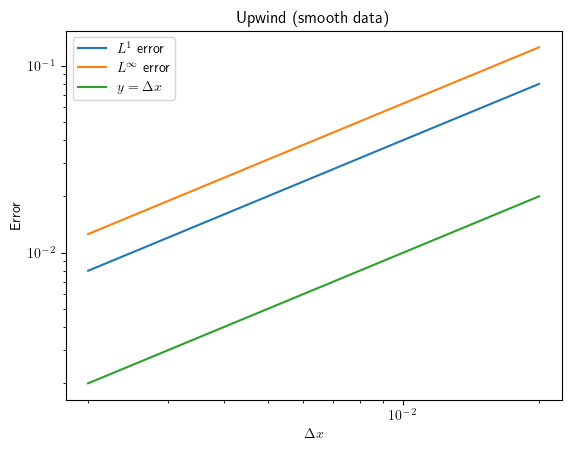

In [14]:
fig, ax = plt.subplots()
ax.loglog([1/J for J in J_list], error_L1, label = r"$L^1$ error")
ax.loglog([1/J for J in J_list], error_Linf, label = r"$L^\infty$ error")
ax.loglog([1/J for J in J_list], [1/J for J in J_list], label = "$y = \Delta x$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Error")
plt.title("Upwind (smooth data)")
plt.legend()

#### Rough data

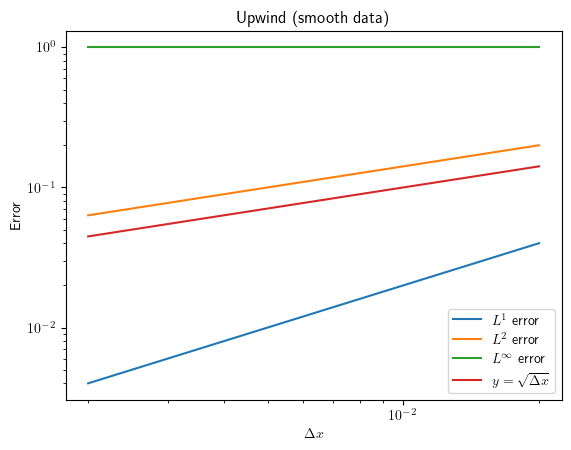

In [17]:
J_list = range(50,501,50)
T=0.5
error_L1 = np.zeros(len(J_list))
error_L2 = np.zeros(len(J_list))
error_Linf = np.zeros(len(J_list))
for i in range(len(J_list)):
    n = int(T*J_list[i])
    u_pwd = upwind(J_list[i],T,n,u0_nonsmooth,1)
    u_ex = [u_sol(k/J_list[i],T,1,u0_nonsmooth) for k in range(J_list[i])]
    error_L1[i] = 1/J_list[i]*np.linalg.norm(u_ex-u_pwd[n-1,:],ord=1)
    error_L2[i] = 1/np.sqrt(J_list[i]*np.linalg.norm(u_ex-u_pwd[n-1,:],ord=2)
    error_Linf[i] = np.linalg.norm(u_ex-u_pwd[n-1,:],ord=np.inf)

fig, ax = plt.subplots()
ax.loglog([1/J for J in J_list], error_L1, label = r"$L^1$ error")
ax.loglog([1/J for J in J_list], error_L2, label = r"$L^2$ error")
ax.loglog([1/J for J in J_list], error_Linf, label = r"$L^\infty$ error")
ax.loglog([1/J for J in J_list], [1/np.sqrt(J) for J in J_list], label = "$y = \sqrt{\Delta x}$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Error")
plt.title("Upwind (smooth data)")
plt.legend()

## Burgers equation

In [36]:
def u0_shock(x):
  if x<-0.5:
    return 1.0
  elif x<0.5:
    return 0.5-x
  else:
    return 0.0

def u0_noshock(x):
  return -np.arctan(x)/np.pi + 0.5

"""
Solve between [-1,1]
"""
def burgers_app(J,T,n,u0):
    dx,dt = 2/J, T/n
    out = np.zeros((n+1,J+1))
    out[0,:] = [u0(k*dx-1) for k in range(J+1)]
    nu = dt/dx
    for i in range(n):
        out[i+1,0] = out[i,0] 
        for k in range(1,J+1):
            out[i+1,k] = out[i,k]-0.5*nu*(out[i,k]**2-out[i,k-1]**2)
    return out

## Shocks

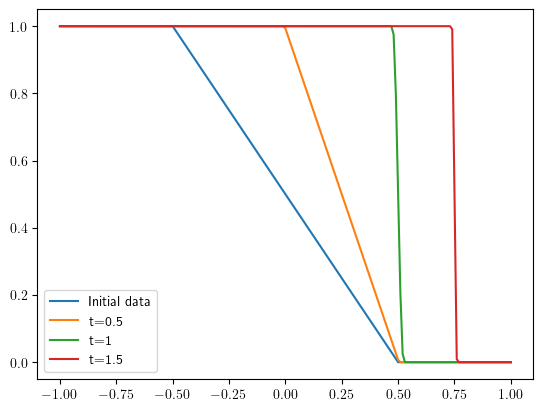

In [34]:
J = 200
T = 0.5
n = int(0.5*T*J)
u_app05 = burgers_app(J,T,n,u0_shock)
T = 1
n = int(0.5*T*J)
u_app1 = burgers_app(J,T,n,u0_shock)
T = 1.5
n = int(0.5*T*J)
u_app15 = burgers_app(J,T,n,u0_shock)

fig, ax = plt.subplots()
ax.plot([2*k/J-1 for k in range(J+1)],[u0_shock(2*k/J-1) for k in range(J+1)],label="Initial data")
ax.plot([2*k/J-1 for k in range(J+1)],u_app05[int(0.5**2*J),:],label=r"t=0.5")
ax.plot([2*k/J-1 for k in range(J+1)],u_app1[int(0.5*J),:],label=r"t=1")
ax.plot([2*k/J-1 for k in range(J+1)],u_app15[int(0.5*J*1.5),:],label=r"t=1.5")
plt.legend()

## No shock

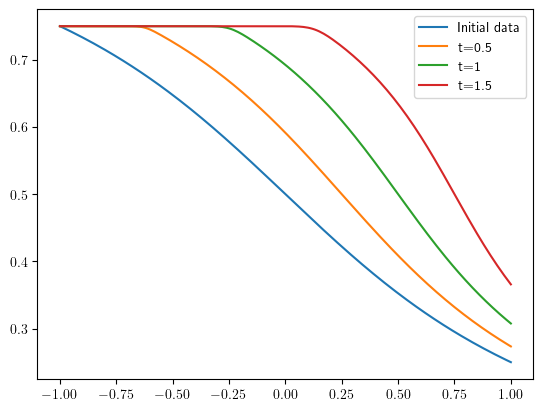

In [37]:
J = 200
T = 0.5
n = int(0.5*T*J)
u_app05 = burgers_app(J,T,n,u0_noshock)
T = 1
n = int(0.5*T*J)
u_app1 = burgers_app(J,T,n,u0_noshock)
T = 1.5
n = int(0.5*T*J)
u_app15 = burgers_app(J,T,n,u0_noshock)

fig, ax = plt.subplots()
ax.plot([2*k/J-1 for k in range(J+1)],[u0_noshock(2*k/J-1) for k in range(J+1)],label="Initial data")
ax.plot([2*k/J-1 for k in range(J+1)],u_app05[int(0.5**2*J),:],label=r"t=0.5")
ax.plot([2*k/J-1 for k in range(J+1)],u_app1[int(0.5*J),:],label=r"t=1")
ax.plot([2*k/J-1 for k in range(J+1)],u_app15[int(0.5*J*1.5),:],label=r"t=1.5")
plt.legend()